# <center>Прогнозирование индекса **S&P100** на своих предыдущих значениях и курсов входящих в него акций. 
# <center>Сравнение архитектур сетей на базе **LSTM** и **Transformers**

In [1]:
# import os
# os.chdir("..")

# %load_ext autoreload
# %autoreload 2

# from dotenv import load_dotenv
# load_dotenv()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('drive/My Drive/Colab Notebooks/neural_OTUS/project1_sp100')

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from tqdm import tqdm

# mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [4]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
import torch.nn.functional as F

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

#### Данные
загрузим ранее подготовленный датасет

In [6]:
path_to_data = "data"

In [7]:
features = pd.read_csv(os.path.join(path_to_data, "sp100.csv"), index_col=0)

In [8]:
features.head()

,AAPL,ABBV,ABT,ACN,ADBE,AIG,ALL,AMGN,AMT,AMZN,AXP,BA,BAC,BIIB,BK,BKNG,BLK,BMY,BRK.B,C,CAT,CHTR,CL,CMCSA,COF,COP,COST,CRM,CSCO,CVS,CVX,DD,DHR,DIS,DOW,DUK,EMR,EXC,F,FB,...,MDLZ,MDT,MET,MMM,MO,MRK,MS,MSFT,NEE,NFLX,NKE,NVDA,ORCL,OXY,PEP,PFE,PG,PM,PYPL,QCOM,RTX,SBUX,SLB,SO,SPG,T,TGT,TMO,TXN,UNH,UNP,UPS,USB,V,VZ,WBA,WFC,WMT,XOM,S&P100
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-18,0.928013,35.119999,15.150405,15.17,16.000000,1445.000000,24.0625,69.0625,38.4375,64.1250,44.220886,45.0000,24.000000,35.687500,39.617340,355.125,18.000,62.162937,34.000000,438.750000,24.96875,35.0,31.50000,16.166666,42.500,16.937721,51.250,4.3,56.00000,18.000000,44.65625,61.823280,8.363343,34.034248,49.799999,46.687752,30.09375,18.84375,29.812790,38.23,...,31.25,44.3750,13.814617,48.56250,23.000000,70.8125,66.87500,57.65625,21.1875,1.196429,6.328125,3.817708,27.81250,10.538675,36.2500,36.500000,58.46875,49.389999,36.709999,69.53125,19.745123,3.257813,33.06250,14.279787,23.029551,41.1250,34.00000,14.4375,55.187500,7.375000,11.093750,68.6875,23.4375,14.125,52.835213,29.2500,19.4375,65.5625,42.37500,795.679993
2000-01-19,0.951451,35.119999,14.841785,15.17,15.781250,1416.666626,23.5625,72.0000,39.0000,66.8125,43.454998,47.6250,24.000000,40.333332,39.352341,374.625,18.250,60.973213,34.180000,448.125000,24.65625,35.0,30.75000,17.145834,43.375,16.794786,51.875,4.3,56.15625,17.906250,43.96875,61.289555,8.268575,34.280876,49.799999,47.995228,30.84375,19.18750,29.366285,38.23,...,31.25,44.9375,13.814617,49.40625,23.375000,71.5000,67.84375,53.50000,21.6875,1.196429,6.601563,3.781250,28.56250,10.688373,36.4375,37.000000,57.68750,49.389999,36.709999,73.31250,19.096130,3.187500,32.93750,14.623419,23.145567,40.5625,34.96875,14.2500,54.750000,7.437500,10.906250,68.2500,23.0000,14.125,51.823475,30.1875,18.3750,64.0625,42.78125,790.309998
2000-01-20,1.013393,35.119999,14.392884,15.17,15.953125,1404.583374,23.7500,71.8125,40.5000,64.7500,44.175297,46.5000,23.539063,40.895832,38.954845,371.625,17.500,58.891201,34.000000,439.570313,23.56250,35.0,30.96875,16.625000,42.375,16.318338,50.000,4.3,56.18750,16.859375,43.75000,59.680962,8.090883,33.171062,49.799999,48.648964,30.21875,18.90625,28.696527,38.23,...,31.25,44.0000,13.814617,47.56250,22.578125,72.9375,67.40625,53.00000,21.4375,1.196429,6.445313,3.770833,29.62500,10.598555,36.1250,36.390625,56.28125,49.389999,36.709999,77.81250,18.663467,3.132813,32.28125,14.547056,23.261585,41.0000,33.84375,14.5000,56.437500,7.625000,10.500000,68.8750,22.1875,14.125,51.992096,30.1875,18.1875,63.3750,41.84375,783.330017
2000-01-21,0.993862,35.119999,14.000096,15.17,15.718750,1385.833374,23.5000,74.6875,43.1250,62.0625,44.257355,45.6875,22.843750,49.250000,38.557346,381.000,17.375,58.236855,34.220001,423.281250,23.68750,35.0,30.65625,16.541666,41.375,16.270695,48.500,4.3,57.62500,17.250000,44.28125,57.938938,7.806577,32.307877,49.799999,49.248226,30.03125,19.43750,27.717651,38.23,...,31.25,43.5625,13.814617,47.46875,22.000000,72.4375,66.25000,51.87500,22.0000,1.196429,6.335938,3.729167,29.84375,10.388979,36.1250,35.062500,51.34375,49.389999,36.709999,77.46875,19.076464,3.121094,33.00000,14.967050,23.551630,43.0000,32.40625,14.4375,55.398438,7.296875,10.937500,67.2500,21.6875,14.125,54.015572,29.9375,18.3125,62.4375,42.50000,779.780029
2000-01-24,0.948661,35.119999,13.467027,15.17,15.140625,1354.166626,22.8125,69.2500,42.0000,70.1250,44.348534,44.3125,22.281250,45.770832,38.424847,359.625,17.125,55.857414,34.000000,413.906250,22.65625,35.0,30.34375,16.166666,41.125,15.913358,47.000,4.3,54.53125,17.218750,44.40625,59.925587,7.202426,32.862782,49.799999,49.901962,29.06250,20.31250,28.095465,38.23,...,31.25,43.0625,13.814617,46.37500,22.000000,70.2500,64.00000,50.62500,21.8750,1.196429,6.210938,3.562500,27.09375,9.999766,35.3125,34.375000,51.56250,49.389999,36.709999,70.03125,18.879799,3.070313,32.15625,15.348863,23.319595,42.0000,31.75000,14.6250,55.437500,6.898438,10.609375,66.0000,21.4375,14.12

In [9]:
features.shape

(5198, 102)

Первые **4500** строк выделим под **обучение**, остальное - под **валидацию**

In [10]:
TRAIN_SPLIT = 4500

Посмотрим для наглядности на целевую переменную и некоторые курсы акций

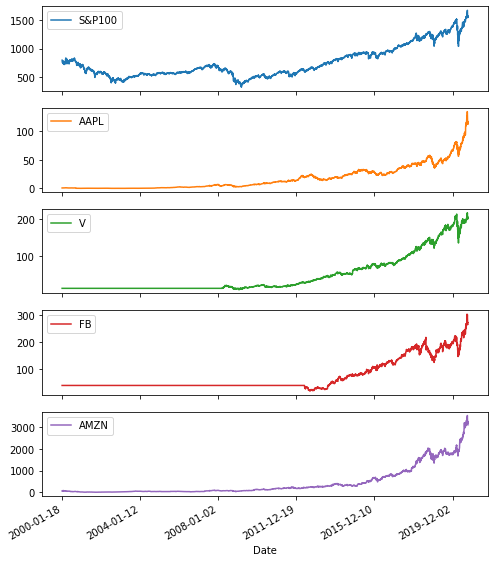

In [11]:
mpl.rcParams['figure.figsize'] = (8, 10)

tickers = ["S&P100", "AAPL", "V", "FB", "AMZN"]
features[tickers].plot(subplots=True);

Стандартизируем (нормализуем) набор данных. Для расчета параметров стандартизации используем только **train**

In [12]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [13]:
dataset = (dataset - data_mean) / data_std

In [14]:
# dataset

Будем делать два варианта прогноза - точечное прогнозирование (одно значение, например - на следующий день) и интервальный прогноз (например - 10 дней вперед, с учетом выходных это будет две недели).    

Вариант просто с классификацией ["buy", ""sell", "hold"] считаю **недостаточным**, так как, считаю, имеет значение величина роста или падения, а не просто направление

## Глобальные параметры

In [15]:
past_history = 90  # смотрим историю за 90 дней (рабочих)
STEP = 1           # данные берем без пропусков

In [16]:
BATCH_SIZE = 64
TARGET_NUM = -1  # номер таргетной фичи в датасете

##  Рабочие функции

In [17]:
class DatasetCustom(Dataset):
    """
    Кастомный класс датасета
    """
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, key):
        return self.x[key], self.y[key]

In [18]:
def train_model(model, dataloaders: dict, optimizer, num_epochs=3):
    since = time.time()

#     history = {'train': [], 'val': []}
    loss_history = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
#         print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
#             running_corrects = 0

            # Iterate over data.
            n_batches = len(dataloaders[phase])
            for inputs, y in dataloaders[phase]:
                inputs = inputs.to(device).float()
                y = y.to(device).float()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = model.loss(outputs, y)

#                     _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
#             epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            loss_history[phase].append(epoch_loss)
#             history[phase].append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return model, loss_history

def test_model(model, testloader):
    n_batches = len(testloader)
    running_loss = 0.0
#     running_corrects = 0

    for inputs, y in tqdm(testloader, total=n_batches):
        inputs = inputs.to(device)
        y = y.to(device)

        outputs = model(inputs)
        loss = model.loss(outputs, y)
#         _, preds = torch.max(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
#         running_corrects += torch.sum(preds == labels.data)

    loss = running_loss / len(testloader.dataset)
#     acc = running_corrects.double() / len(testloader.dataset)
    print('Val Loss: {:.4f}'.format(loss))
    return loss

In [19]:
def loss_history_plot(loss_history, title):
    loss = loss_history['train']
    val_loss = loss_history['val']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.xlabel("Epochs")
    plt.legend()

    plt.show()

In [20]:
def history_predict_plot(history, true_future, predictions: dict=None, title='', target_num=TARGET_NUM):
  def create_time_steps(length):
    return list(range(-length, 0))
    
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, target_num]), label='History', marker=".")
  plt.plot(np.arange(num_out).flatten() / STEP, np.array(true_future).flatten(), 'go-',
           label='True Future')
  if predictions is not None:
      for marker, prediction in zip(['rx-', 'mx-','yx-','cx-','bx-',], predictions):
        plt.plot(np.arange(num_out).flatten() / STEP, np.array(predictions[prediction]).flatten(), marker,
                label=prediction)
  plt.legend(loc='upper left')
  plt.title(title)
  plt.show()

In [21]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    """
    Функция организации временных интервалов
    """
    
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels).reshape((len(labels), -1))

## Построение модели

Архитектура класса модели позволяет строить сеть как с использованием ячеек **LSTM**, так и с использованием **Transformers**

In [22]:
class SP100LstmTransNet(nn.Module):
    
    def __init__(self, predict_num, criterion=None, 
                 input_size=102, seq_len=90, 
                 dropout=0.1, hidden_size =100,
                 lstm_or_trans: str="lstm",
                 lstm_num_layers=2, num_enc_dec_layers=6,
                 has_conv=True, second_cell=True, 
                 ):
        super().__init__()
        self.input_size = input_size
        self.seq_len = seq_len
        self.hidden_size = hidden_size  # должно делиться на цело на nhead=10
        self.predict_num = predict_num
        self.lstm_or_trans = lstm_or_trans
        self.criterion = criterion
        self.lstm_num_layers = lstm_num_layers
        self.num_enc_dec_layers = num_enc_dec_layers
        self.second_cell = second_cell
        self.has_conv = has_conv
        
        self.fc_input = nn.Linear(input_size, hidden_size)
        self.conv1 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)
        self.bn_c1 = nn.BatchNorm1d(hidden_size)
        self.ln_c1 = nn.LayerNorm([hidden_size, seq_len])
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)
        self.bn_c2 = nn.BatchNorm1d(hidden_size)
        self.ln_c2 = nn.LayerNorm([hidden_size, seq_len])
        self.lstm1 = nn.LSTM(hidden_size, hidden_size, lstm_num_layers, 
                             dropout=dropout)
        self.trans1 = nn.Transformer(d_model=hidden_size, nhead=10, dropout=dropout, 
                                     num_encoder_layers=num_enc_dec_layers, 
                                     num_decoder_layers=num_enc_dec_layers)
        self.ln_lstm1 = nn.LayerNorm([seq_len, hidden_size])
        # self.bn_lstm1 = nn.BatchNorm1d(seq_len)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, lstm_num_layers, 
                                 dropout=dropout)
        self.trans2 = nn.Transformer(d_model=hidden_size, nhead=10, dropout=dropout, 
                                     num_encoder_layers=num_enc_dec_layers, 
                                     num_decoder_layers=num_enc_dec_layers)
        self.ln_lstm2 = nn.LayerNorm([seq_len, hidden_size])
        # self.bn_lstm2 = nn.BatchNorm1d(seq_len)

        self.fc1 = nn.Linear(seq_len * hidden_size, hidden_size)
        self.ln_fc1 = nn.LayerNorm(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn_fc2 = nn.BatchNorm1d(hidden_size)
        self.fc3 = nn.Linear(hidden_size, predict_num)

    def forward(self, x):
        chunk_len = x.shape[0]  # длинна батча или группы данных на входе
        x = x.float()

        x = self.fc_input(x.reshape(-1, self.input_size)).reshape(-1, self.seq_len, self.hidden_size)
        # conv block
        if self.has_conv:
            x = F.relu(self.conv1(x.transpose(1, 2)))  # (cl, hs, sl)
            # x = self.bn_c1(x)
            x = self.ln_c1(x)
            x = F.relu(self.conv2(x))  # (cl, hs, sl)
            # x = self.bn_c2(x)
            x = self.ln_c2(x)
            x = x.transpose(1, 2)  # (cl, sl, hs)

        # lstm/transformers block
        if self.lstm_or_trans == "lstm":
            x = self.lstm1(x.transpose(1, 0))[0].transpose(1, 0)  #  change to "batch first", (cl, sl, hs)
        elif self.lstm_or_trans == "trans":
            tgt = torch.zeros((self.seq_len, chunk_len, self.hidden_size)).to(device)
            x = self.trans1(x.transpose(1, 0), tgt).transpose(1, 0)  #  (cl, sl, hs)
        else:
            raise ValueError(f"Parameter 'lstm_or_trans' must be one of 'lstm' or 'trans' but got '{self.lstm_or_trans}'")

        x = self.ln_lstm1(x)  # (cl, sl, hs)
        # x = self.bn_lstm1(x)  # (cl, sl, hs)

        if self.second_cell:
            if self.lstm_or_trans == "lstm":
                x = self.lstm2(x.transpose(1, 0))[0].transpose(1, 0)  #  change to "batch first", (cl, sl, hs)
            elif self.lstm_or_trans == "trans":
                tgt = torch.zeros((self.seq_len, chunk_len, self.hidden_size)).to(device)
                x = self.trans2(x.transpose(1, 0), tgt).transpose(1, 0)  #  (cl, sl, hs)
            else:
                raise ValueError(f"Parameter 'lstm_or_trans' must be one of 'lstm' or 'trans' but got '{self.lstm_or_trans}'")

            x = self.ln_lstm2(x)  # (cl, sl, hs)
            # x = self.bn_lstm2(x)  # (cl, sl, hs)
        
        # full connect output block
        x = x.reshape(chunk_len, self.seq_len * self.hidden_size)
        x = F.relu(self.fc1(x))
        x = self.ln_fc1(x)
        x = F.relu(self.fc2(x))
        x = self.bn_fc2(x)
        x = self.fc3(x)
        return x
    
    def loss(self, outputs, targets):
        return self.criterion(outputs, targets).mean()

### Проверим модель на корректность

In [23]:
x_test = torch.randn([32, 90, 102])
target_num_test = 10
x_test.shape, target_num_test

(torch.Size([32, 90, 102]), 10)

#### LSTM - mode

In [24]:
model = SP100LstmTransNet(target_num_test, lstm_or_trans="lstm").to(device)
assert model(x_test.to(device)).shape == (x_test.shape[0], target_num_test)

model = SP100LstmTransNet(target_num_test, lstm_or_trans="lstm", 
                          has_conv=False, second_cell=False).to(device)
assert model(x_test.to(device)).shape == (x_test.shape[0], target_num_test)

model(x_test.to(device)).shape

torch.Size([32, 10])

#### Transformers - mode

In [25]:
model = SP100LstmTransNet(target_num_test, lstm_or_trans="trans").to(device)
assert model(x_test.to(device)).shape == (x_test.shape[0], target_num_test)

model = SP100LstmTransNet(target_num_test, lstm_or_trans="trans", 
                          has_conv=False, second_cell=False).to(device)
assert model(x_test.to(device)).shape == (x_test.shape[0], target_num_test)

model(x_test.to(device)).shape

torch.Size([32, 10])

## <center>Точечное прогнозирование

In [75]:
future_target = 1  # предсказываем только 1 следующий день

### Сформирум размеченный временной ряд

In [76]:
x_train_single, y_train_single = multivariate_data(dataset, dataset[:, TARGET_NUM], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, TARGET_NUM],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)
x_train_single.shape, y_train_single.shape

((4410, 90, 102), (4410, 1))

### Создадим загрузчик данных по батчам

In [77]:
train_single_dataset = DatasetCustom(x_train_single, y_train_single)
val_single_dataset = DatasetCustom(x_val_single, y_val_single)

In [78]:
dataloader_train = DataLoader(train_single_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              drop_last=False
                              )

dataloader_val = DataLoader(val_single_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            drop_last=False
                            )
len(dataloader_train), len(dataloader_val)

(69, 10)

Инициализируем архив точечных моделей

In [116]:
single_models = {}

### Готовим и тренируем модель: LSTM

#### 1) lstm, conv 

In [117]:
%%time

dataloaders = {
    "train": dataloader_train, 
    "val": dataloader_val
}

model = SP100LstmTransNet(
    predict_num=future_target, criterion=nn.MSELoss(), 
    dropout=0.2, hidden_size=100, 
    lstm_or_trans="lstm", lstm_num_layers=2, 
    has_conv=True, second_cell=False,
).to(device)
optimizer = torch.optim.Adadelta(model.parameters())

model, loss_history = train_model(
    model=model, dataloaders=dataloaders, 
    optimizer=optimizer, num_epochs=10)

single_models["LSTM Conv"] = model

Epoch 1/10
train Loss: 0.1882
val Loss: 7.8821

Epoch 2/10
train Loss: 0.1084
val Loss: 8.2415

Epoch 3/10
train Loss: 0.0741
val Loss: 8.0072

Epoch 4/10
train Loss: 0.0576
val Loss: 9.4108

Epoch 5/10
train Loss: 0.0466
val Loss: 10.8059

Epoch 6/10
train Loss: 0.0430
val Loss: 10.5851

Epoch 7/10
train Loss: 0.0429
val Loss: 9.8491

Epoch 8/10
train Loss: 0.0393
val Loss: 10.9457

Epoch 9/10
train Loss: 0.0432
val Loss: 10.5813

Epoch 10/10
train Loss: 0.0362
val Loss: 11.3039

Training complete in 0m 31s
CPU times: user 24.8 s, sys: 6.62 s, total: 31.4 s
Wall time: 31.6 s


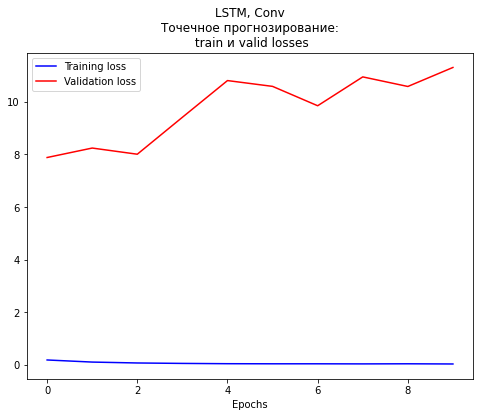

In [118]:
mpl.rcParams['figure.figsize'] = (8, 6)

loss_history_plot(loss_history,
                   'LSTM, Conv\nТочечное прогнозирование:\n train и valid losses')

#### 2) lstm, not conv 

In [119]:
%%time

dataloaders = {
    "train": dataloader_train, 
    "val": dataloader_val
}

model = SP100LstmTransNet(
    predict_num=future_target, criterion=nn.MSELoss(), 
    dropout=0.2, hidden_size=100, 
    lstm_or_trans="lstm", lstm_num_layers=2, 
    has_conv=False, second_cell=False,
).to(device)
optimizer = torch.optim.Adadelta(model.parameters())

model, loss_history = train_model(
    model=model, dataloaders=dataloaders, 
    optimizer=optimizer, num_epochs=10)

single_models["LSTM NotConv"] = model

Epoch 1/10
train Loss: 0.1848
val Loss: 8.4990

Epoch 2/10
train Loss: 0.0789
val Loss: 7.6468

Epoch 3/10
train Loss: 0.0598
val Loss: 8.7220

Epoch 4/10
train Loss: 0.0517
val Loss: 8.8835

Epoch 5/10
train Loss: 0.0442
val Loss: 10.0396

Epoch 6/10
train Loss: 0.0449
val Loss: 9.1077

Epoch 7/10
train Loss: 0.0362
val Loss: 8.6341

Epoch 8/10
train Loss: 0.0417
val Loss: 8.5747

Epoch 9/10
train Loss: 0.0434
val Loss: 8.5383

Epoch 10/10
train Loss: 0.0357
val Loss: 8.8941

Training complete in 0m 27s
CPU times: user 21.5 s, sys: 5.67 s, total: 27.1 s
Wall time: 27.2 s


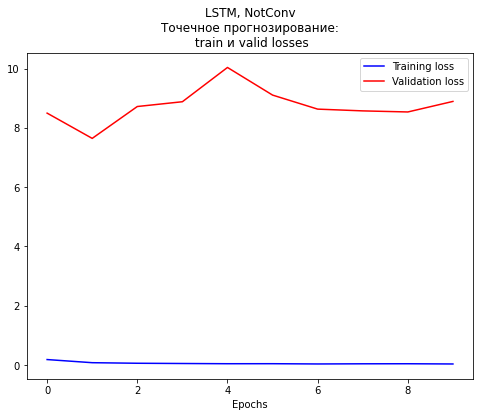

In [120]:
mpl.rcParams['figure.figsize'] = (8, 6)

loss_history_plot(loss_history,
                   'LSTM, NotConv\nТочечное прогнозирование:\n train и valid losses')

### Тест-прогнозы

In [121]:
# for x, y in list(dataloader_val)[:10]:
#     print(x[:1].to(device).shape)

In [1]:
# for x, y in list(dataloader_val)[:10]:
#   history_predict_plot(x[0], y[0], 
#                        {key + " Predicted": model(x[:1].to(device)).detach().cpu().numpy() 
#                                         for key, model in single_models.items()},  
#                        "Точечное прогнозирование")

### Готовим и тренируем модель: Transformers

#### 3) trans, conv 

In [128]:
%%time

dataloaders = {
    "train": dataloader_train, 
    "val": dataloader_val
}

model = SP100LstmTransNet(
    predict_num=future_target, criterion=nn.MSELoss(), 
    dropout=0.2, hidden_size=100, 
    lstm_or_trans="trans", num_enc_dec_layers=6, 
    has_conv=True, second_cell=False,
).to(device)
optimizer = torch.optim.Adadelta(model.parameters())

model, loss_history = train_model(
    model=model, dataloaders=dataloaders, 
    optimizer=optimizer, num_epochs=10)

single_models["Trans Conv"] = model

Epoch 1/10
train Loss: 0.4296
val Loss: 17.8994

Epoch 2/10
train Loss: 0.7417
val Loss: 17.2862

Epoch 3/10
train Loss: 1.0530
val Loss: 49.4627

Epoch 4/10
train Loss: 1.0401
val Loss: 51.5149

Epoch 5/10
train Loss: 1.0281
val Loss: 8.4001

Epoch 6/10
train Loss: 1.0237
val Loss: 12.9339

Epoch 7/10
train Loss: 1.0246
val Loss: 12.7121

Epoch 8/10
train Loss: 1.0249
val Loss: 13.6942

Epoch 9/10
train Loss: 1.0219
val Loss: 13.7801

Epoch 10/10
train Loss: 1.0229
val Loss: 13.6990

Training complete in 4m 52s
CPU times: user 3min 12s, sys: 1min 39s, total: 4min 51s
Wall time: 4min 52s


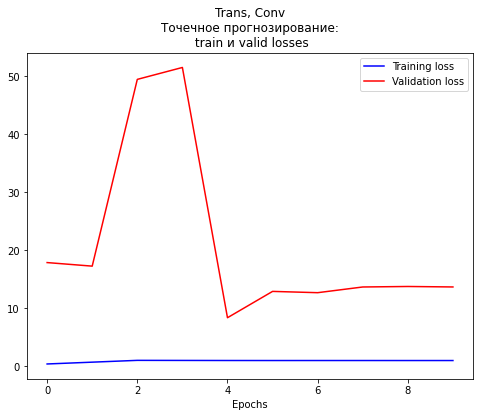

In [129]:
mpl.rcParams['figure.figsize'] = (8, 6)

loss_history_plot(loss_history,
                   'Trans, Conv\nТочечное прогнозирование:\n train и valid losses')

#### 2) trans, not conv 

In [130]:
%%time

dataloaders = {
    "train": dataloader_train, 
    "val": dataloader_val
}

model = SP100LstmTransNet(
    predict_num=future_target, criterion=nn.MSELoss(), 
    dropout=0.2, hidden_size=100, 
    lstm_or_trans="trans", num_enc_dec_layers=6, 
    has_conv=False, second_cell=False,
).to(device)
optimizer = torch.optim.Adadelta(model.parameters())

model, loss_history = train_model(
    model=model, dataloaders=dataloaders, 
    optimizer=optimizer, num_epochs=10)

single_models["Trans NotConv"] = model

Epoch 1/10
train Loss: 0.1683
val Loss: 6.4376

Epoch 2/10
train Loss: 0.1057
val Loss: 5.4270

Epoch 3/10
train Loss: 0.1220
val Loss: 15.3840

Epoch 4/10
train Loss: 0.0727
val Loss: 8.6343

Epoch 5/10
train Loss: 0.0569
val Loss: 7.7345

Epoch 6/10
train Loss: 0.0502
val Loss: 18.3213

Epoch 7/10
train Loss: 0.0603
val Loss: 10.5421

Epoch 8/10
train Loss: 0.0450
val Loss: 7.8812

Epoch 9/10
train Loss: 0.0443
val Loss: 12.6917

Epoch 10/10
train Loss: 0.0530
val Loss: 7.2298

Training complete in 4m 49s
CPU times: user 3min 9s, sys: 1min 39s, total: 4min 48s
Wall time: 4min 49s


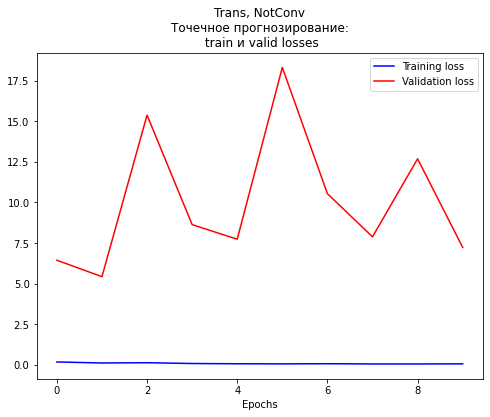

In [131]:
mpl.rcParams['figure.figsize'] = (8, 6)

loss_history_plot(loss_history,
                   'Trans, NotConv\nТочечное прогнозирование:\n train и valid losses')

### Тест-прогнозы

In [132]:
# for x, y in list(dataloader_val)[:10]:
#     print(x[:1].to(device).shape)

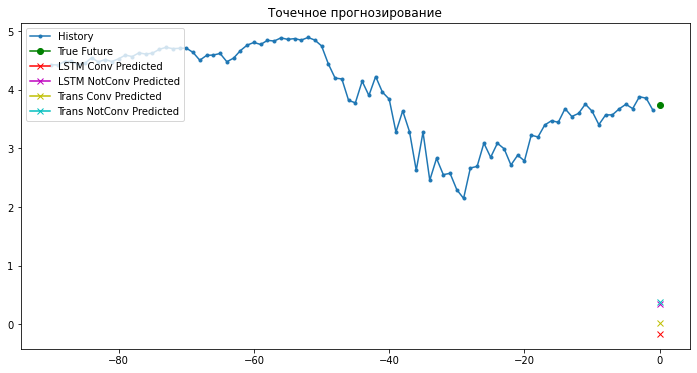

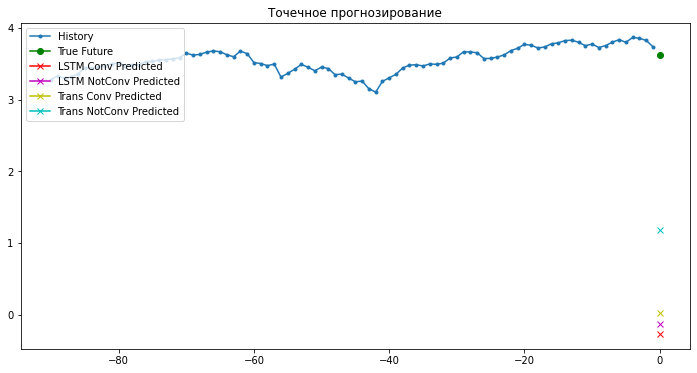

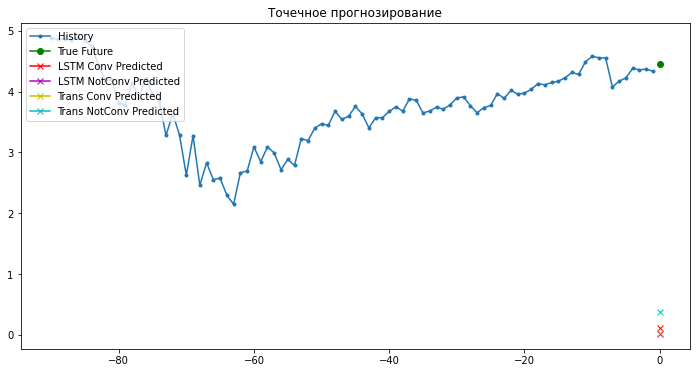

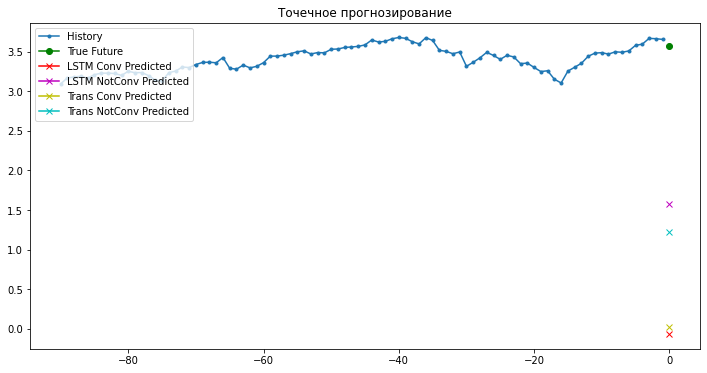

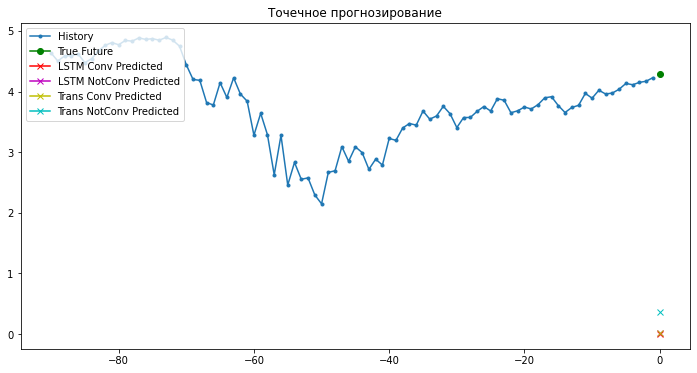

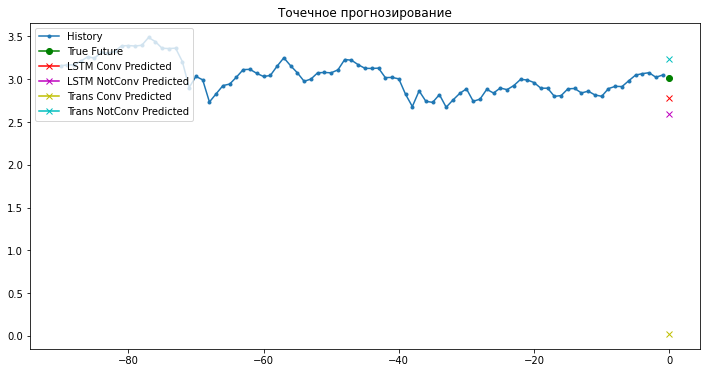

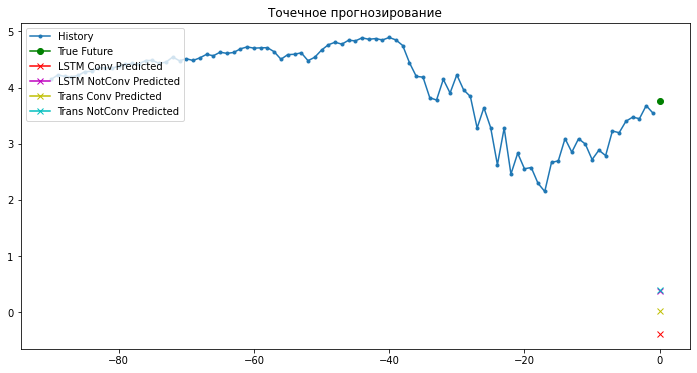

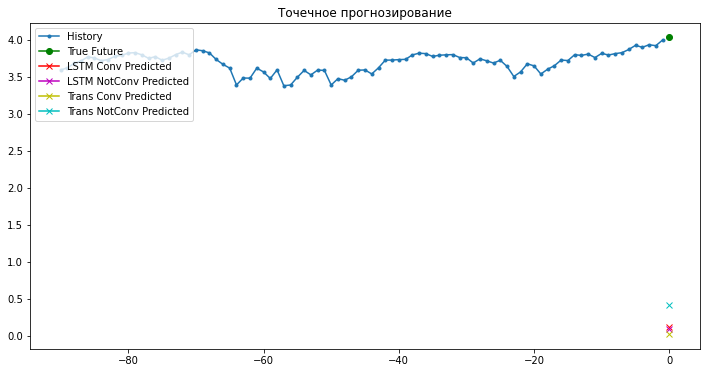

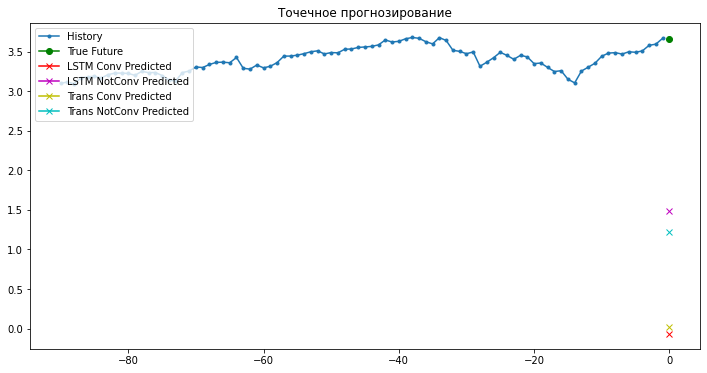

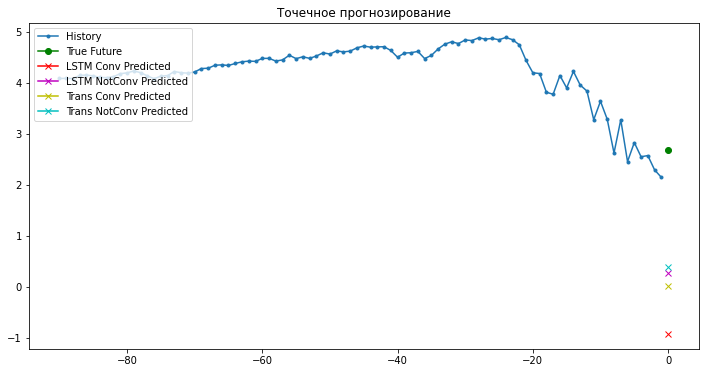

In [133]:
for x, y in list(dataloader_val)[:10]:
  history_predict_plot(x[0], y[0], 
                       {key + " Predicted": model(x[:1].to(device)).detach().cpu().numpy() 
                                        for key, model in single_models.items()}, 
                       "Точечное прогнозирование")

## <center>Интервальное прогнозирование
Прогнозирование **интервала** будущих значений

Будем прогнозировать на 10 дней вперед

In [26]:
future_target_multi = 10  # число дней прогнозирований

### Сформирум размеченный временной ряд

In [27]:
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, TARGET_NUM], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target_multi, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, TARGET_NUM],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target_multi, STEP)
x_train_multi.shape, y_train_multi.shape

((4410, 90, 102), (4410, 10))

### Создадим загрузчик данных по батчам

In [28]:
train_multi_dataset = DatasetCustom(x_train_multi, y_train_multi)
val_multi_dataset = DatasetCustom(x_val_multi, y_val_multi)

In [29]:
train_multi_dataloader = DataLoader(train_multi_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              drop_last=True
                              )

val_multi_dataloader = DataLoader(val_multi_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            drop_last=True
                            )

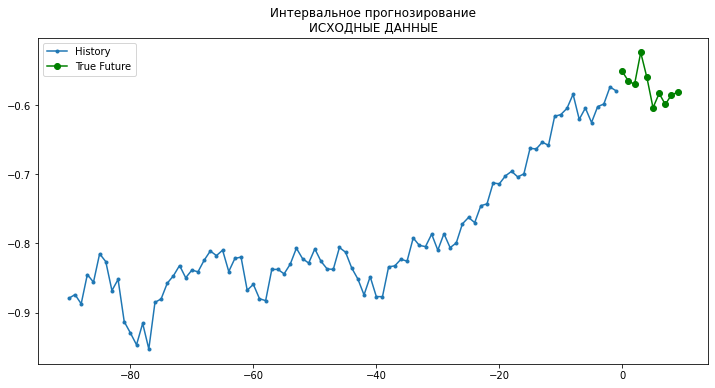

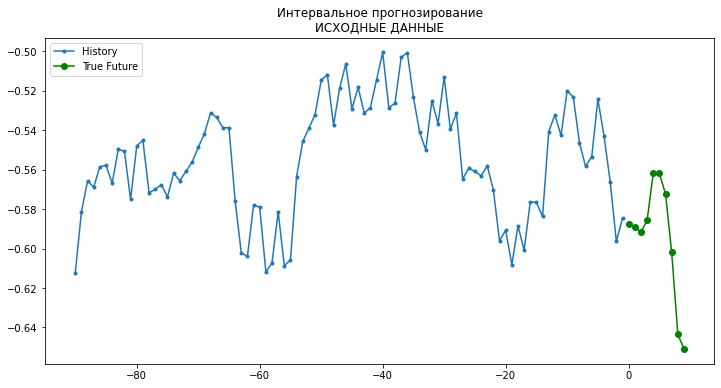

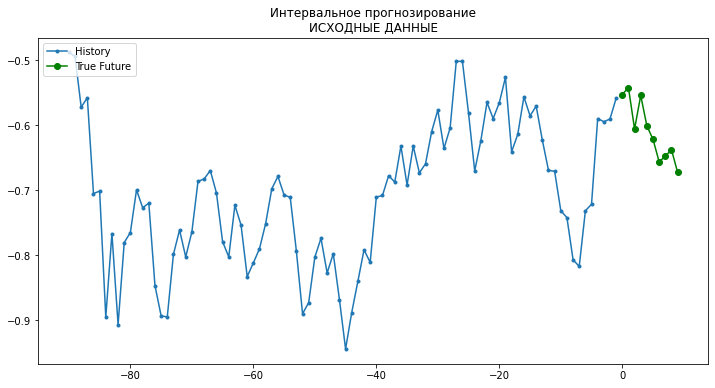

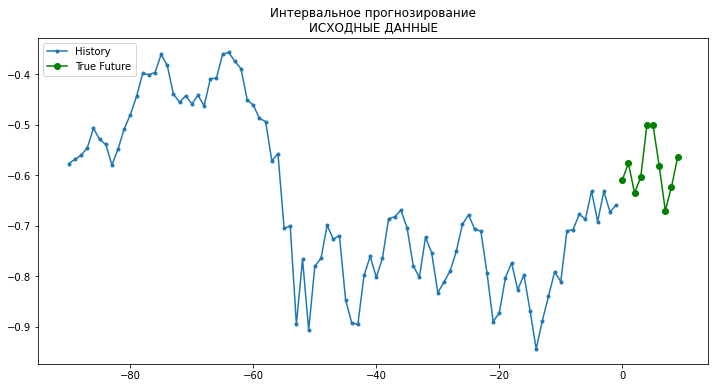

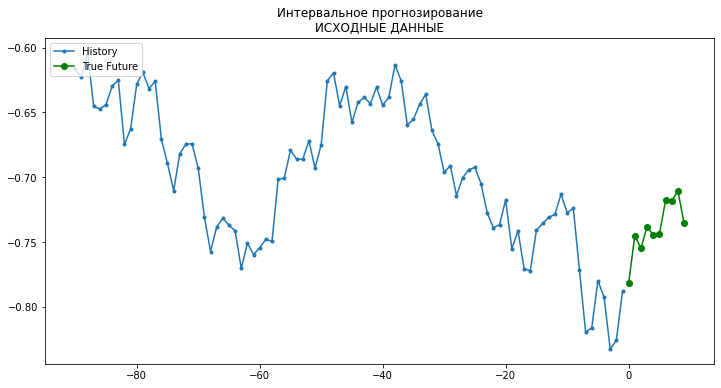

In [30]:
for x, y in list(train_multi_dataloader)[:5]:
    # print(y[0])
    history_predict_plot(x[0], y[0], None, "Интервальное прогнозирование\nИСХОДНЫЕ ДАННЫЕ")

Инициализируем архив интервальных (**multi**) моделей

In [33]:
multi_models = {}

### Готовим и тренируем модель: LSTM

#### 1) lstm, conv 

In [34]:
%%time

dataloaders = {
    "train": train_multi_dataloader, 
    "val": val_multi_dataloader
}

model = SP100LstmTransNet(
    predict_num=future_target_multi, criterion=nn.MSELoss(), 
    dropout=0.2, hidden_size=100, 
    lstm_or_trans="lstm", lstm_num_layers=2, 
    has_conv=True, second_cell=True,  # added second_cell
).to(device)
optimizer = torch.optim.Adadelta(model.parameters())

model, loss_history = train_model(
    model=model, dataloaders=dataloaders, 
    optimizer=optimizer, num_epochs=10)

multi_models["LSTM Conv"] = model

Epoch 1/10
train Loss: 0.2094
val Loss: 7.0140

Epoch 2/10
train Loss: 0.0710
val Loss: 7.3937

Epoch 3/10
train Loss: 0.0715
val Loss: 10.1843

Epoch 4/10
train Loss: 0.0705
val Loss: 6.0572

Epoch 5/10
train Loss: 0.0533
val Loss: 5.9674

Epoch 6/10
train Loss: 0.0434
val Loss: 6.4231

Epoch 7/10
train Loss: 0.0489
val Loss: 7.0453

Epoch 8/10
train Loss: 0.0495
val Loss: 6.2981

Epoch 9/10
train Loss: 0.0359
val Loss: 5.8104

Epoch 10/10
train Loss: 0.0462
val Loss: 6.6328

Training complete in 0m 59s
CPU times: user 43.8 s, sys: 15 s, total: 58.8 s
Wall time: 58.9 s


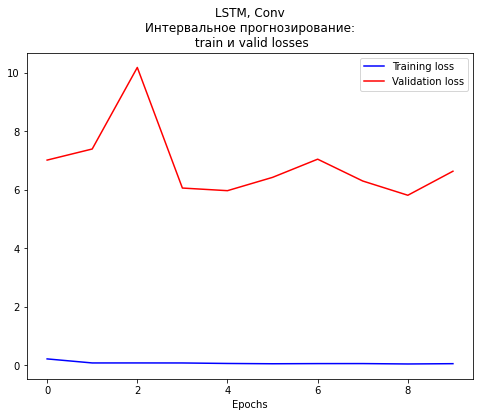

In [36]:
mpl.rcParams['figure.figsize'] = (8, 6)

loss_history_plot(loss_history,
                   'LSTM, Conv\nИнтервальное прогнозирование:\n train и valid losses')

#### 2) lstm, not conv 

In [38]:
%%time

dataloaders = {
    "train": train_multi_dataloader, 
    "val": val_multi_dataloader
}

model = SP100LstmTransNet(
    predict_num=future_target_multi, criterion=nn.MSELoss(), 
    dropout=0.2, hidden_size=100, 
    lstm_or_trans="lstm", lstm_num_layers=2, 
    has_conv=False, second_cell=True,  # added second_cell
).to(device)
optimizer = torch.optim.Adadelta(model.parameters())

model, loss_history = train_model(
    model=model, dataloaders=dataloaders, 
    optimizer=optimizer, num_epochs=10)

multi_models["LSTM NotConv"] = model

Epoch 1/10
train Loss: 0.1436
val Loss: 11.1395

Epoch 2/10
train Loss: 0.1014
val Loss: 9.7762

Epoch 3/10
train Loss: 0.0709
val Loss: 8.4906

Epoch 4/10
train Loss: 0.0536
val Loss: 7.5399

Epoch 5/10
train Loss: 0.0519
val Loss: 8.1009

Epoch 6/10
train Loss: 0.0495
val Loss: 7.0034

Epoch 7/10
train Loss: 0.0504
val Loss: 7.0140

Epoch 8/10
train Loss: 0.0442
val Loss: 7.7452

Epoch 9/10
train Loss: 0.0433
val Loss: 7.8411

Epoch 10/10
train Loss: 0.0547
val Loss: 8.1869

Training complete in 0m 59s
CPU times: user 43 s, sys: 16.2 s, total: 59.2 s
Wall time: 59.3 s


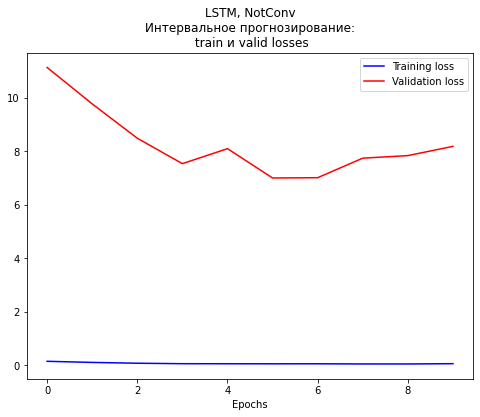

In [39]:
mpl.rcParams['figure.figsize'] = (8, 6)

loss_history_plot(loss_history,
                   'LSTM, NotConv\nИнтервальное прогнозирование:\n train и valid losses')

### Тест-прогнозы

In [ ]:
# for x, y in list(val_multi_dataloader)[:10]:
#     print(x[:1].to(device).shape)

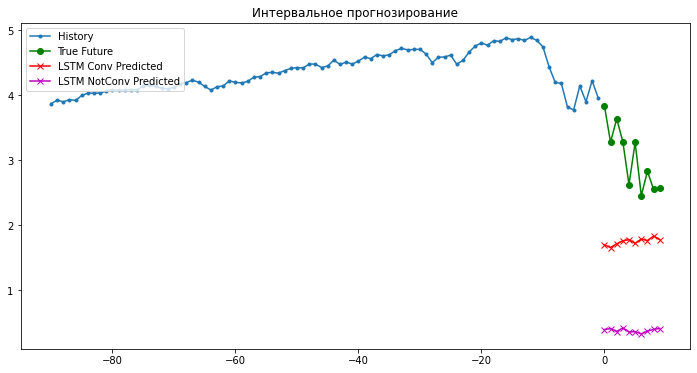

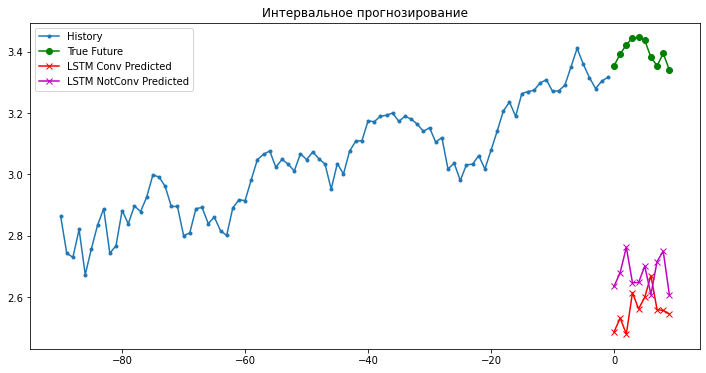

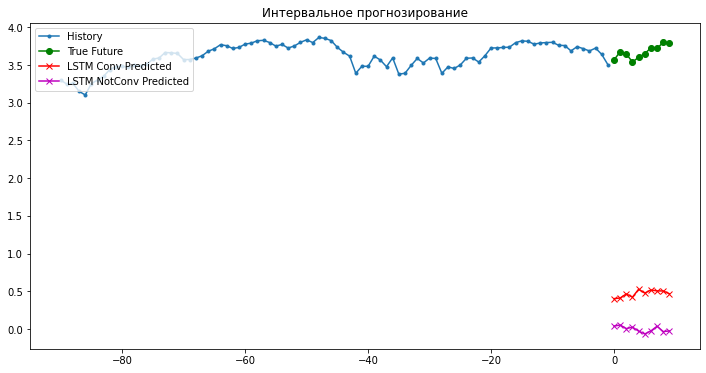

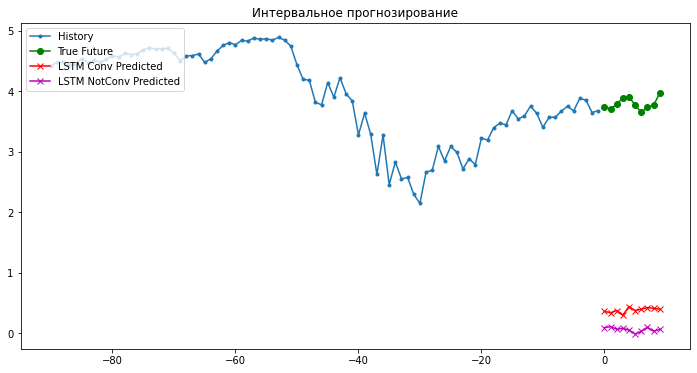

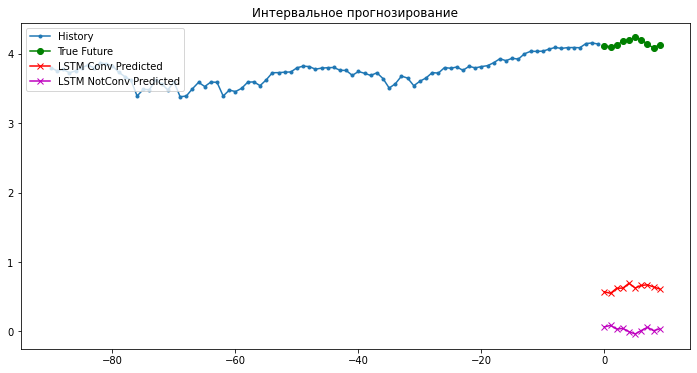

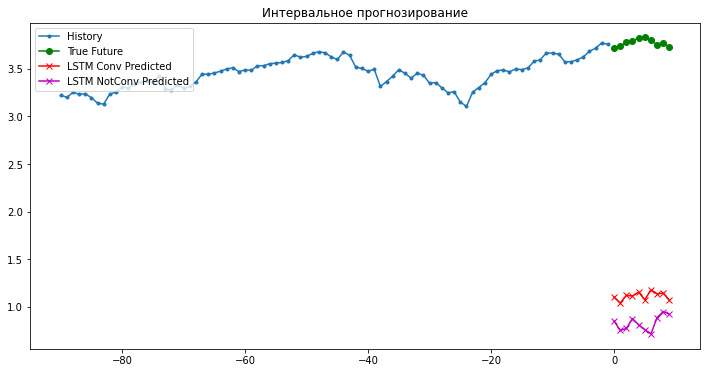

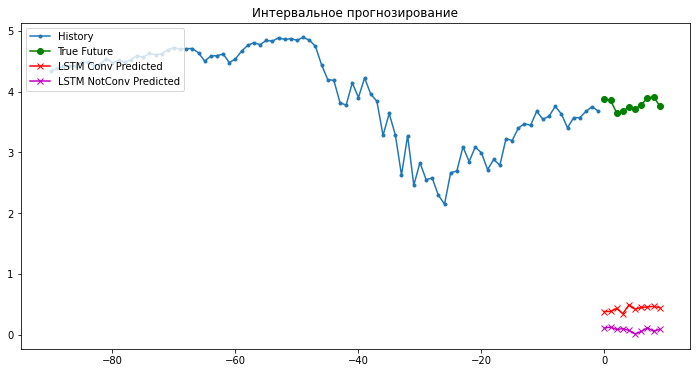

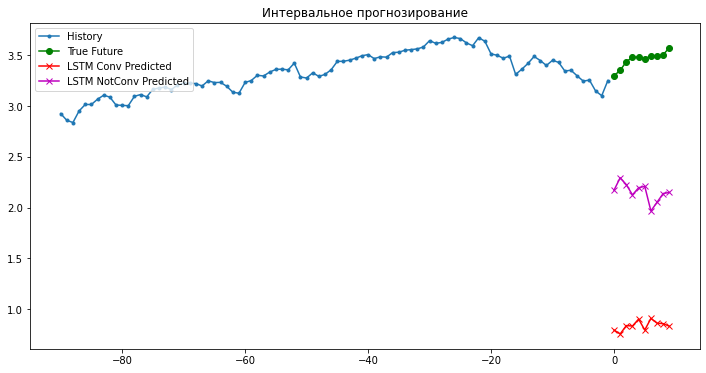

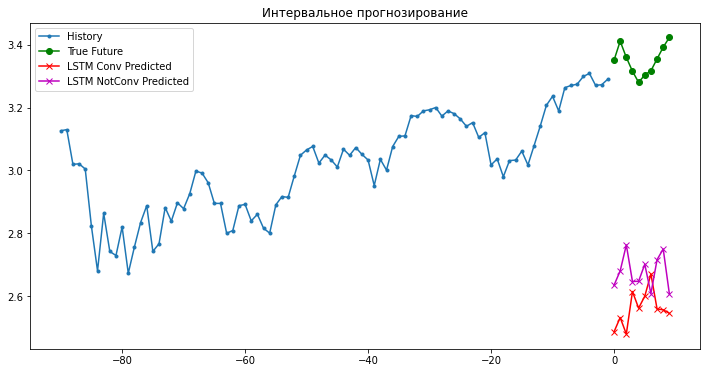

In [41]:
for x, y in list(val_multi_dataloader)[:10]:
  history_predict_plot(x[0], y[0], 
                       {key + " Predicted": model(x[:1].to(device)).detach().cpu().numpy() 
                                        for key, model in multi_models.items()},  
                       "Интервальное прогнозирование")

### Готовим и тренируем модель: Transformers

#### 3) trans, conv 

In [42]:
%%time

dataloaders = {
    "train": train_multi_dataloader, 
    "val": val_multi_dataloader
}

model = SP100LstmTransNet(
    predict_num=future_target_multi, criterion=nn.MSELoss(),  
    dropout=0.2, hidden_size=100, 
    lstm_or_trans="trans", num_enc_dec_layers=6, 
    has_conv=True, second_cell=True,  # added second_cell
).to(device)
optimizer = torch.optim.Adadelta(model.parameters())

model, loss_history = train_model(
    model=model, dataloaders=dataloaders, 
    optimizer=optimizer, num_epochs=10)

multi_models["Trans Conv"] = model

Epoch 1/10
train Loss: 1.0357
val Loss: 12.6270

Epoch 2/10
train Loss: 1.0145
val Loss: 13.3193

Epoch 3/10
train Loss: 1.0130
val Loss: 13.4571

Epoch 4/10
train Loss: 1.0134
val Loss: 12.8011

Epoch 5/10
train Loss: 1.0166
val Loss: 12.8027

Epoch 6/10
train Loss: 1.0164
val Loss: 13.2801

Epoch 7/10
train Loss: 1.0116
val Loss: 13.0727

Epoch 8/10
train Loss: 1.0154
val Loss: 13.5180

Epoch 9/10
train Loss: 1.0114
val Loss: 13.1550

Epoch 10/10
train Loss: 1.0182
val Loss: 12.6946

Training complete in 9m 17s
CPU times: user 6min 6s, sys: 3min 8s, total: 9min 14s
Wall time: 9min 16s


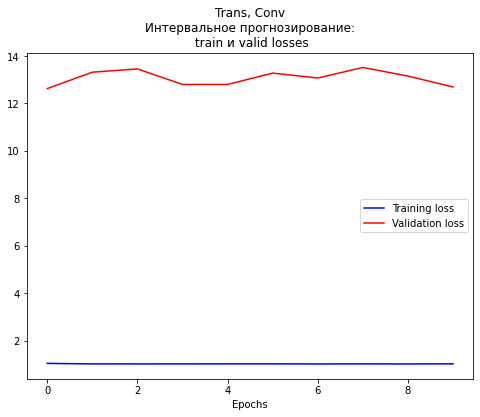

In [43]:
mpl.rcParams['figure.figsize'] = (8, 6)

loss_history_plot(loss_history,
                   'Trans, Conv\nИнтервальное прогнозирование:\n train и valid losses')

#### 2) trans, not conv 

In [44]:
%%time

dataloaders = {
    "train": train_multi_dataloader, 
    "val": val_multi_dataloader
}

model = SP100LstmTransNet(
    predict_num=future_target_multi, criterion=nn.MSELoss(),  
    dropout=0.2, hidden_size=100, 
    lstm_or_trans="trans", num_enc_dec_layers=6, 
    has_conv=False, second_cell=True,  # added second_cell
).to(device)
optimizer = torch.optim.Adadelta(model.parameters())

model, loss_history = train_model(
    model=model, dataloaders=dataloaders, 
    optimizer=optimizer, num_epochs=10)

multi_models["Trans NotConv"] = model

Epoch 1/10
train Loss: 0.7960
val Loss: 12.9723

Epoch 2/10
train Loss: 0.7577
val Loss: 18.4260

Epoch 3/10
train Loss: 1.0225
val Loss: 8.8914

Epoch 4/10
train Loss: 1.0207
val Loss: 13.1674

Epoch 5/10
train Loss: 1.0128
val Loss: 13.7319

Epoch 6/10
train Loss: 1.0211
val Loss: 13.1517

Epoch 7/10
train Loss: 1.0144
val Loss: 13.4642

Epoch 8/10
train Loss: 1.0163
val Loss: 13.2872

Epoch 9/10
train Loss: 1.0123
val Loss: 12.3741

Epoch 10/10
train Loss: 1.0150
val Loss: 13.6183

Training complete in 9m 13s
CPU times: user 6min 3s, sys: 3min 7s, total: 9min 11s
Wall time: 9min 13s


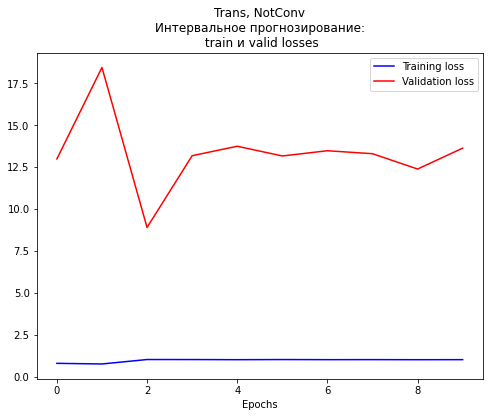

In [45]:
mpl.rcParams['figure.figsize'] = (8, 6)

loss_history_plot(loss_history,
                   'Trans, NotConv\nИнтервальное прогнозирование:\n train и valid losses')

### Тест-прогнозы

In [ ]:
# for x, y in list(val_multi_dataloader)[:10]:
#     print(x[:1].to(device).shape)

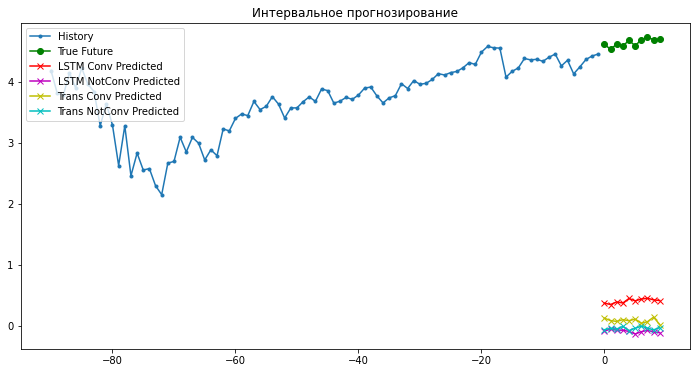

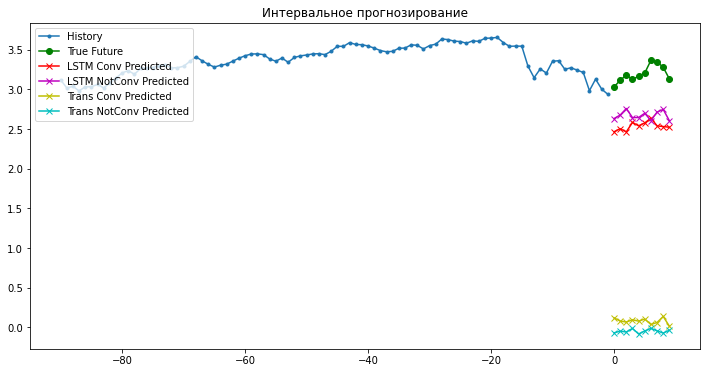

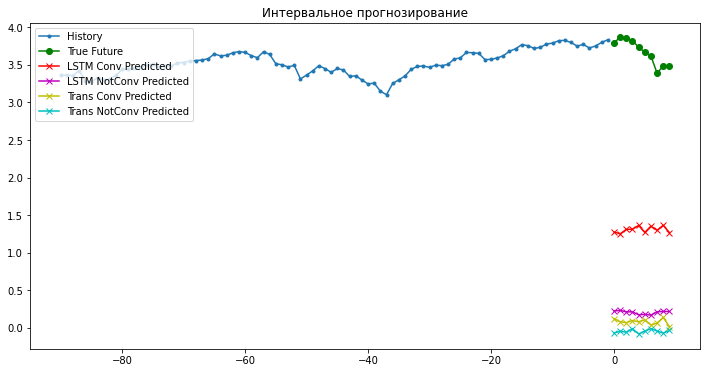

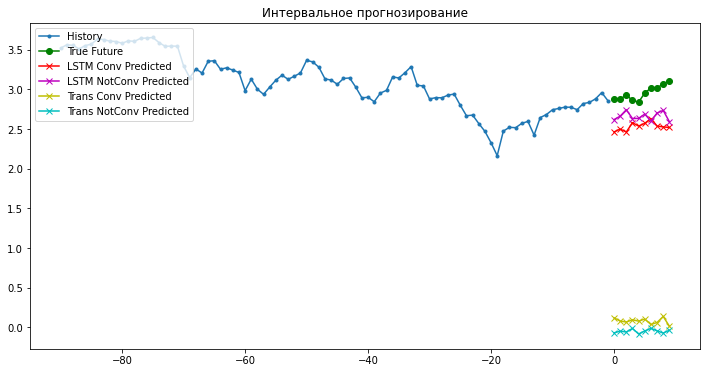

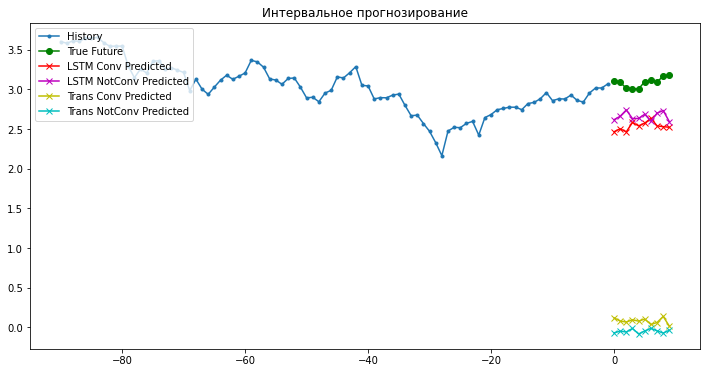

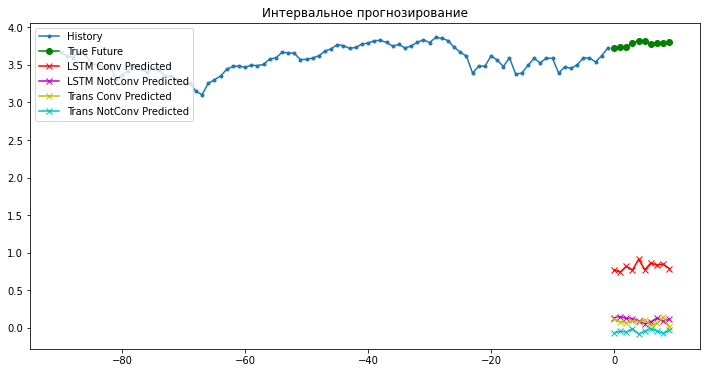

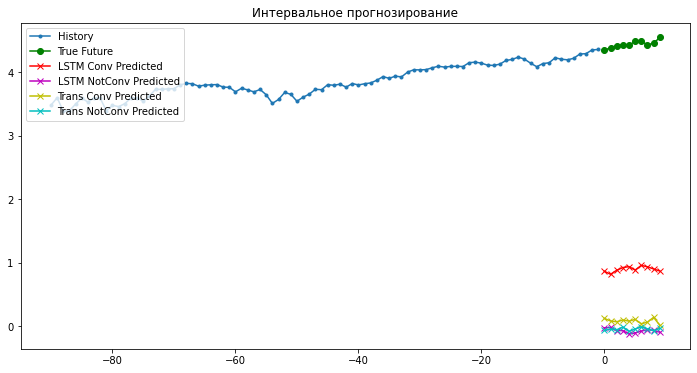

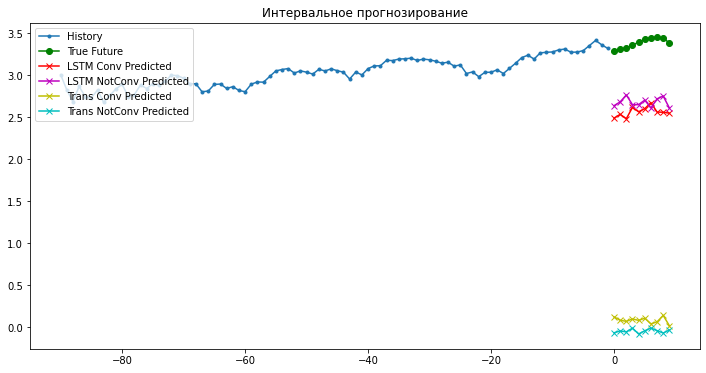

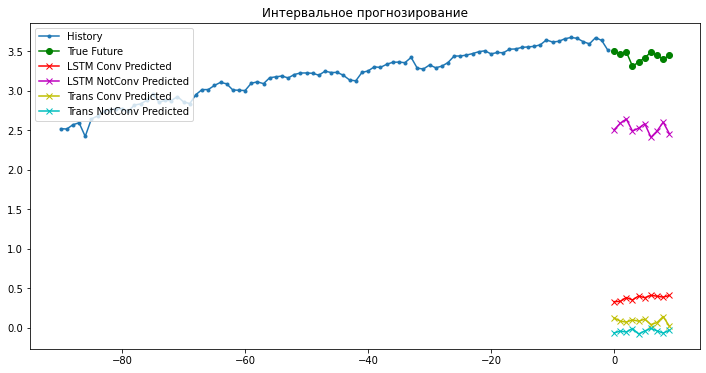

In [46]:
for x, y in list(val_multi_dataloader)[:10]:
  history_predict_plot(x[0], y[0], 
                       {key + " Predicted": model(x[:1].to(device)).detach().cpu().numpy() 
                                        for key, model in multi_models.items()}, 
                       "Интервальное прогнозирование")